In [ ]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest ,  f_classif
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings("ignore")

# Pre-defined User Functions:

## *Analyzing*:

In [ ]:
def check_for_nulls_per(x):
    table = {'\033[1m' + '\n Null Values By Count \n' + '\033[0m' :  x.isna().sum().sort_values(ascending=False),
             '\033[1m' + '\n Null Values By Percentage \n' + '\033[0m': round((x.isnull().sum() * 100/ len(x)),2).sort_values(ascending=False),
        }
    table_df = pd.DataFrame(table)

    with pd.option_context('display.max_rows', None,):
        print(table_df)

## *Re-engineering*:

In [ ]:
def redefine_target_feature(x):
    print('\033[1m' + '\n Redifining the Target Feature to :\n 0 - Normal, 1 - Prediabetic, 2 - diabetic: \n' + '\033[0m')
    # 0 - Normal, 1 - Prediabetic, 2 - diabetic
    df_diabetes_final = x
    df_diabetes_final.loc[df_diabetes_final['GlycoHemoglobin'] < 5.7, 'Diabetes'] = 0
    df_diabetes_final.loc[(df_diabetes_final['GlycoHemoglobin'] >= 5.7) & (df_diabetes_final['GlycoHemoglobin'] <= 6.4), 'Diabetes'] = 1
    df_diabetes_final.loc[df_diabetes_final['GlycoHemoglobin'] >= 6.5, 'Diabetes'] = 2

    return df_diabetes_final

## *Cleaning*:

In [ ]:
def remove_outliers_by_target():

    print('\033[1m' + '\n Boxplot: \n' + '\033[0m')
    sns.boxplot(df_main['GlycoHemoglobin'])
    plt.show()

    values = (np.where(df_main['GlycoHemoglobin']>15))
    values_1 = np.ravel(values)
    print("Outliers are :", values_1)
    df_main.drop(values_1, inplace=True)

def treat_by_lambda(x,column_names):
    for col in column_names:
        x[col] = x[col].apply(lambda i: i if i > 0 else 0)
    
    return x

def treat_by_mode(x, column_names):
    for col in column_names:
        x[col] = x[col].fillna(x[col].mode()[0])

    return x

def treat_by_median(x, column_names):
    for col in column_names:
        x[col] = x[col].fillna(x[col].median())

    return x

def treat_by_one(x, column_names):
    for col in column_names:
       x[col] = x[col].fillna(value = 1)

    return x

def treat_by_mean(x, column_names):
    for col in column_names:
        x[col] = x[col].fillna(x[col].mean())

    return x

def treat_by_ffil(x, column_names):
    for col in column_names:
        x[col] = x[col].fillna(method='ffill')

    return x

## *Correlation*:

In [ ]:
def corr_matrix_abs(x):
    corr_matrix = x.corr().abs() # Create correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # Select upper triangle of correlation matrix
    to_drop = [column for column in upper.columns if any(upper[column] > 0.80)] # Find features with correlation greater than 0.80
    x.drop(to_drop, axis=1, inplace=True) # Drop  
    return x

def select_best_40_features(x):
    corr_matrix = x.corr() # Compute the correlation matrix
    pos_corr_cols = corr_matrix.nlargest(20, "Diabetes")["Diabetes"].index.tolist() # Select the top 20 most positively correlated columns
    neg_corr_cols = corr_matrix.nsmallest(20, "Diabetes")["Diabetes"].index.tolist() # Select the top 20 most negatively correlated columns
    selected_cols = pos_corr_cols + neg_corr_cols # Combine the lists of positively and negatively correlated columns
    x = x[selected_cols]
    return x

def check_correlation_matrix(x):
    corr_matrix = x.corr()
    print(corr_matrix["Diabetes"].sort_values(ascending=False))

## *Plots*:

In [ ]:
def plot_heatmap(x):
    colormap = plt.cm.viridis
    plt.figure(figsize=(30,30))
    sns.heatmap(x.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

## *Save File*:

In [ ]:
def save_file_csv(x, file_name):
    x.to_csv(file_name, index=False, encoding="utf-8")

# Storing the csv file to Colab Local Memory:

In [ ]:
!gdown --id 1YlBB1cgYVgqQv73fBwgnIevZfMg65hsb

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YlBB1cgYVgqQv73fBwgnIevZfMg65hsb
To: /content/NHANES_Categorical_Merged_2013_14.csv
100% 52.3M/52.3M [00:00<00:00, 102MB/s] 


In [ ]:
df_diabetes_initial = pd.read_csv('NHANES_Categorical_Merged_2013_14.csv')
df_diabetes_initial

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73557,8,2,1,69,NaN,4,4,1,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
2,73558,8,2,1,54,NaN,3,3,1,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
3,73558,8,2,1,54,NaN,3,3,1,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
4,73558,8,2,1,54,NaN,3,3,1,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15747,83724,8,2,1,80,NaN,3,3,1,NaN,...,NaN,NaN,173.0,140.0,71.0,190.0,55.0,NaN,NaN,NaN
15748,83724,8,2,1,80,NaN,3,3,1,NaN,...,NaN,NaN,173.0,140.0,71.0,190.0,55.0,NaN,NaN,NaN
15749,83724,8,2,1,80,NaN,3,3,1,NaN,...,NaN,NaN,173.0,140.0,71.0,190.0,55.0,NaN,NaN,NaN
15750,83727,8,2,1,26,NaN,2,2,2,NaN,...,NaN,NaN,NaN,NaN,NaN,150.0,26.0,NaN,NaN,NaN


In [ ]:
df_diabetes_initial.shape

(15752, 1825)

In [ ]:
df_diabetes_initial = df_diabetes_initial.drop_duplicates()

In [ ]:
df_diabetes_initial.shape

(15739, 1825)

# Selecting Important Features By Domain Knowledge:

In [ ]:
#Shruthi Selected features:

#Selecting Features:
df_important = df_diabetes_initial[['SEQN','INDFMPIR','MCQ300C','DRABF','RIAGENDR','RIDAGEYR','RIDRETH1','RIDRETH3','DMDBORN4',
                                    'MGDCGSZ','BMDAVSAD','BMXWAIST','BMXARMC',
                                    'URXUCR','LBXIN','LBXGH','DMDYRSUS']]

#Renaming the columns:
df_important = df_important.rename(columns = {
                          'SEQN' : 'id',
                          'RIAGENDR' : 'Gender',
                          'DMDYRSUS' : 'Years_in_US', 
                          'INDFMPIR' : 'Family_income',
                          'LBXGH' : 'GlycoHemoglobin',
                          'BMXARMC' : 'ArmCircum',
                          'BMDAVSAD' : 'SaggitalAbdominal',
                          'MGDCGSZ' : 'GripStrength',
                          'DRABF' : 'Breast_fed',
                          'LBXIN' : 'Insulin',
                          'MCQ300C' : 'Family_History',
                          'RIDAGEYR' : 'Age_while_screening',
                          'URXUCR' : 'Creatinine_urine',
                          'DMDBORN4' : 'Country_Of_Birth',
                          'RIDRETH1' : 'Race_Hispanic_Origin',
                          'RIDRETH3' : 'Race_Hispanic_Origin_whAsian',
                          'BMXWAIST' : 'waist_circum'
                          })

In [ ]:
df_important.head()

,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,SaggitalAbdominal,waist_circum,ArmCircum,Creatinine_urine,Insulin,GlycoHemoglobin,Years_in_US
0,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,20.6,100.0,35.3,NaN,NaN,13.9,NaN
1,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,20.6,100.0,35.3,NaN,NaN,13.9,NaN
2,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,24.4,107.6,34.7,NaN,NaN,9.1,NaN
3,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,24.4,107.6,34.7,NaN,NaN,9.1,NaN
4,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,24.4,107.6,34.7,NaN,NaN,9.1,NaN


In [ ]:
df_important.shape

(15739, 17)

In [ ]:
#Harsimran Selected features:

#Selecting Features:
df_important_1 = df_diabetes_initial[[ 'DR1TALCO', 'DR1TVB12', 'DR1TCAFF',
                          'DR1TCALC', 'DR1TCARB', 'DR1TCHL', 'DR1TCHOL',
                          'DR1TCOPP', 'DR1TFA', 'DR1TFDFE', 'DR1TFIBE', 'DR1TIRON', 
                          'DR1TKCAL', 'DR1TLYCO', 'DR1TLZ', 'DR1TMAGN', 
                          'DR1TZINC', 'DR1TVB2', 'DR1TVB6', 'DR1TVC', 'DR1TVD', 
                          'DR1TVK', 'DR1TMFAT', 'DR1TNIAC', 'DR1TPFAT',
                          'DR1TPHOS', 'DR1TPOTA', 'DR1TPROT', 'DR1TSELE', 'DR1TSFAT',
                          'DR1TSODI', 'DR1TSUGR', 'DR1TTFAT']]

#Renaming the columns:
df_important_1 = df_important_1.rename(columns = {
                          'DR1TALCO' : 'Alcohol',
                          'DR1IVB12' : 'Vitamin_B12_Med',
                          'DR1TCAFF' : 'Caffeine_Med',
                          'DR1TCALC' : 'Calcium_Med',
                          'DR1TCARB' : 'Carbohydrate_Med',
                          'DR1TCHL' : 'Total_choline_Med',
                          'DR1TCHOL' : 'Cholesterol_Med',
                          'DR1TCOPP' : 'Copper_Med',
                          'DR1TFA' : 'Folic_acid_Med',
                          'DR1TFDFE' : 'Folate_Med',
                          'DR1TFIBE' : 'Dietary_fiber_Med',
                          'DR1TIRON' : 'Iron_Med',
                          'DR1TKCAL' : 'Energy_Med',
                          'DR1TLYCO' : 'Lycopene_Med',
                          'DR1TLZ' : 'Lutein_zeaxanthin_Med',
                          'DR1TMAGN' : 'Magnesium_Med',
                          'DR1TZINC' : 'Zinc_Med',
                          'DR1TVB2' : 'Vitamin_B2_Med',
                          'DR1TVB6' : 'Vitamin_B6_Med',
                          'DR1TVC' : 'Vitamin_C_Med',
                          'DR1TVD' : 'Vitamin_D_Med',
                          'DR1TVK' : 'Vitamin_K_Med',
                          'DR1TVB12' : 'Thiamin_Med',
                          'DR1TMFAT' : 'Total_monosaturated_fatty_acids_Med',
                          'DR1TNIAC' : 'Niacin_Med',
                          'DR1TPFAT' : 'Total_polyunsaturated_fatty_acids_Med',
                          'DR1TPHOS' : 'Phosphorus_Med',
                          'DR1TPOTA' : 'Potassium_Med',
                          'DR1TPROT' : 'Protein_Med',
                          'DR1TSELE' : 'Selenium_Med',
                          'DR1TSFAT' : 'Total_saturated_fatty_acids_Med',
                          'DR1TSODI' : 'Sodium_Med',
                          'DR1TSUGR' : 'Total_sugars_Med',
                          'DR1TTFAT' : 'Total_fat_Med'})

In [ ]:
df_important_1.head()

,Alcohol,Thiamin_Med,Caffeine_Med,Calcium_Med,Carbohydrate_Med,Total_choline_Med,Cholesterol_Med,Copper_Med,Folic_acid_Med,Folate_Med,...,Niacin_Med,Total_polyunsaturated_fatty_acids_Med,Phosphorus_Med,Potassium_Med,Protein_Med,Selenium_Med,Total_saturated_fatty_acids_Med,Sodium_Med,Total_sugars_Med,Total_fat_Med
0,0.0,2.79,203.0,949.0,239.59,216.3,209.0,1.072,66.0,330.0,...,11.804,8.829,756.0,2228.0,43.63,62.5,17.819,1323.0,176.47,52.81
1,0.0,2.79,203.0,949.0,239.59,216.3,209.0,1.072,66.0,330.0,...,11.804,8.829,756.0,2228.0,43.63,62.5,17.819,1323.0,176.47,52.81
2,119.0,21.45,240.0,3193.0,423.78,2149.0,2584.0,4.130,601.0,1662.0,...,65.396,20.505,6427.0,4930.0,338.13,715.8,53.408,9726.0,44.99,124.29
3,119.0,21.45,240.0,3193.0,423.78,2149.0,2584.0,4.130,601.0,1662.0,...,65.396,20.505,6427.0,4930.0,338.13,715.8,53.408,9726.0,44.99,124.29
4,119.0,21.45,240.0,3193.0,423.78,2149.0,2584.0,4.130,601.0,1662.0,...,65.396,20.505,6427.0,4930.0,338.13,715.8,53.408,9726.0,44.99,124.29


In [ ]:
df_important_1.shape

(15739, 33)

In [ ]:
#Shweta Selected features:
#Selecting Features: 
df_important_2 = df_diabetes_initial[['LBXSGL',
                                    'LBXSOSSI',
                                    'LBXSTR',
                                    'LBXSBU',
                                    'URXUMA',
                                    'LBXSGB',
                                    'LBXRDW',
                                    'LBXSCR',
                                    'LBXSKSI',
                                    'LBXSCLSI',
                                    'LBXSAL',
                                    'LBXSNASI',
                                    'LBDHDD',
                                    'LBXSIR',
                                    'LBXSTB',
                                    'LBXMC',
                                    'LBDHEG',
                                    'WTSH2YR.x',
                                    'LBXSPH']]

#Renaming the columns:
df_important_2 = df_important_2.rename(columns = {
                          'LBXSGL': 'Glucose_lab',
                          'LBXSOSSI': 'Osmolality_lab',
                          'LBXSTR': 'Triglycerides_lab',
                          'LBXSBU':'Blood_urea_nitrogen_lab',
                          'URXUMA':'Albumin_urine_lab',
                          'LBXSGB' :'Globulin_lab',
                          'LBXSCR' :'Creatinine_lab',
                          'LBXSKSI' : 'Potassium_lab',
                          'LBXSCLSI' : 'Chloride_lab',
                          'LBXSAL':'Albumin_lab',
                          'LBXSNASI' :'Sodium_lab',
                          'LBDHDD':'Direct_HDL_Cholesterol_lab',
                          'LBXSIR': 'Iron_lab',
                          'LBXSTB': 'Total_bilirubin_lab',
                          'LBXMC': 'Mean_hemoglobin_lab',
                          'LBDHEG' :'Hepatitis_E_IgG_lab',
                          'WTSH2YR.x': 'Blood_metal_weights_lab',
                          'LBXSPH' : 'Phosphorus_lab'
                          })

In [ ]:
df_important_2.head()

,Glucose_lab,Osmolality_lab,Triglycerides_lab,Blood_urea_nitrogen_lab,Albumin_urine_lab,Globulin_lab,LBXRDW,Creatinine_lab,Potassium_lab,Chloride_lab,Albumin_lab,Sodium_lab,Direct_HDL_Cholesterol_lab,Iron_lab,Total_bilirubin_lab,Mean_hemoglobin_lab,Hepatitis_E_IgG_lab,Blood_metal_weights_lab,Phosphorus_lab
0,554.0,296.0,140.0,10.0,4.3,2.4,14.0,1.21,4.3,97.0,4.1,136.0,65.0,58.0,0.8,33.4,2.0,NaN,4.3
1,554.0,296.0,140.0,10.0,4.3,2.4,14.0,1.21,4.3,97.0,4.1,136.0,65.0,58.0,0.8,33.4,2.0,NaN,4.3
2,219.0,265.0,257.0,16.0,153.0,3.1,13.4,0.79,4.3,98.0,4.7,128.0,50.0,79.0,0.9,32.5,2.0,49123.40002,3.9
3,219.0,265.0,257.0,16.0,153.0,3.1,13.4,0.79,4.3,98.0,4.7,128.0,50.0,79.0,0.9,32.5,2.0,49123.40002,3.9
4,219.0,265.0,257.0,16.0,153.0,3.1,13.4,0.79,4.3,98.0,4.7,128.0,50.0,79.0,0.9,32.5,2.0,49123.40002,3.9


In [ ]:
df_important_2.shape

(15739, 19)

In [ ]:
#Saumya Selected features:

#Selecting Features:
df_important_3 = df_diabetes_initial[['PEASCST1','PEASCTM1','BPXPLS','BPXPULS',
                                          'BPXML1','BPXSY1','BPXDI1','BPXSY2',
                                          'BPXDI2','BMXWT','BMXBMI','MGDSEAT',
                                          'MGXH1T1E','CSXEXSTS','CSQ245']]
                                    
# #Renaming the columns:
df_important_3 = df_important_3.rename(columns = {
                          'PEASCST1' : 'BP_status',
                          'PEASCTM1' : 'BP_Time_sec',
                          'BPXPLS' : '60_sec_pulse',
                          'BPXPULS' : 'Pulse',
                          'BPXML1' : 'MIL',
                          'BPXSY1' : 'Systolic_BP_FR',
                          'BPXDI1' : 'Diastolic_BP_FR',
                          'BPXSY2' : 'Systolic_BP_SR',
                          'BPXDI2' : 'Diastolic_BP_SR',
                          'BMXWT' : 'Weight(kg)',
                          'BMXBMI' : 'BMI',
                          'MGDSEAT' : 'Testing_position',
                          'MGXH1T1E' : 'questionable_effort',
                          'CSXEXSTS' : 'Overall_Status',
                          'CSQ245' : 'skin_rash_allergy_by_quinine'
                          })   

In [ ]:
df_important_3.shape

(15739, 15)

In [ ]:
df_important_3.head()

,BP_status,BP_Time_sec,60_sec_pulse,Pulse,MIL,Systolic_BP_FR,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine
0,1,620.0,86.0,1.0,140.0,122.0,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0
1,1,620.0,86.0,1.0,140.0,122.0,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0
2,1,766.0,74.0,1.0,170.0,156.0,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0
3,1,766.0,74.0,1.0,170.0,156.0,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0
4,1,766.0,74.0,1.0,170.0,156.0,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0


In [ ]:
df_important_3.shape

(15739, 15)

# Merging the selected Features to one DataFrame:

In [ ]:
save_file_csv(df_important, "df_important.csv")
save_file_csv(df_important_1, "df_important_1.csv")
save_file_csv(df_important_2, "df_important_2.csv")
save_file_csv(df_important_3, "df_important_3.csv")

In [ ]:
dataframe1 = pd.read_csv("df_important.csv",low_memory=False)
dataframe2 = pd.read_csv("df_important_1.csv", low_memory=False)
dataframe3 = pd.read_csv("df_important_2.csv", low_memory=False)
dataframe4 = pd.read_csv("df_important_3.csv",low_memory=False)
df_main = pd.concat([dataframe1, dataframe2, dataframe3, dataframe4], axis=1)

In [ ]:
df_main.shape

(15739, 84)

In [ ]:
# dp = df_main.drop_duplicates()

In [ ]:
df_main.describe()

,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,...,Systolic_BP_FR,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine
count,15739.000000,14665.000000,14294.000000,14261.0,15739.000000,15739.000000,15739.000000,15739.000000,15739.000000,14064.000000,...,14252.00000,14252.000000,14852.000000,14852.000000,15516.000000,15447.000000,13091.000000,14449.000000,11836.000000,11397.000000
mean,78545.452316,2.338352,1.702672,2.0,1.547493,53.448504,3.112777,3.251350,1.228350,65.172703,...,124.87272,67.561184,124.875034,67.095206,83.274504,30.087078,1.093805,1.053706,1.221105,2.263139
std,2926.874907,1.597443,1.238234,0.0,0.497755,19.903888,1.094494,1.377655,1.409653,21.523706,...,19.23474,14.143455,19.029267,14.795455,24.160121,7.951014,0.291568,0.225445,0.494017,1.351515
min,73557.000000,0.000000,1.000000,2.0,1.000000,12.000000,1.000000,1.000000,1.000000,14.800000,...,66.00000,0.000000,66.000000,0.000000,29.200000,13.400000,1.000000,1.000000,1.000000,1.000000
25%,75991.000000,1.000000,1.000000,2.0,1.000000,40.000000,3.000000,3.000000,1.000000,49.700000,...,112.00000,60.000000,112.000000,60.000000,66.400000,24.600000,1.000000,1.000000,1.000000,2.000000
50%,78506.000000,1.890000,2.000000,2.0,2.000000,57.000000,3.000000,3.000000,1.000000,61.600000,...,122.00000,68.000000,122.000000,68.000000,79.200000,28.600000,1.000000,1.000000,1.000000,2.000000
75%,81033.000000,3.750000,2.000000,2.0,2.000000,70.000000,4.000000,4.000000,1.000000,80.100000,...,136.00000,76.000000,136.000000,76.000000,96.200000,34.000000,1.000000,1.000000,1.000000,2.000000
max,83729.000000,5.000000,9.000000,2.0,2.000000,80.000000,5.000000,7.000000,77.000000,162.800000,...,228.00000,122.000000,230.000000,116.000000,222.600000,82.900000,2.000000,2.000000,3.000000,9.000000


In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739 entries, 0 to 15738
Data columns (total 84 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     15739 non-null  int64  
 1   Family_income                          14665 non-null  float64
 2   Family_History                         14294 non-null  float64
 3   Breast_fed                             14261 non-null  float64
 4   Gender                                 15739 non-null  int64  
 5   Age_while_screening                    15739 non-null  int64  
 6   Race_Hispanic_Origin                   15739 non-null  int64  
 7   Race_Hispanic_Origin_whAsian           15739 non-null  int64  
 8   Country_Of_Birth                       15739 non-null  int64  
 9   GripStrength                           14064 non-null  float64
 10  SaggitalAbdominal                      14102 non-null  float64
 11  wa

In [ ]:
check_for_nulls_per(df_main)

                                       \n Null Values By Count \n  \
Years_in_US                                                         12525   
Creatinine_urine                                                    10609   
Insulin                                                              8592   
Blood_metal_weights_lab                                              8043   
skin_rash_allergy_by_quinine                                         4342   
Overall_Status                                                       3903   
Testing_position                                                     2648   
GripStrength                                                         1675   
SaggitalAbdominal                                                    1637   
Systolic_BP_FR                                                       1487   
Diastolic_BP_FR                                                      1487   
Zinc_Med                                                             1478   
Niacin_

## Treating Outliers:

In [ ]:
print('\033[1m' + '\n Shape Before Treating Outliers:' + '\033[0m', df_main.shape)


 Shape Before Treating Outliers: (15739, 84)



 Boxplot: 



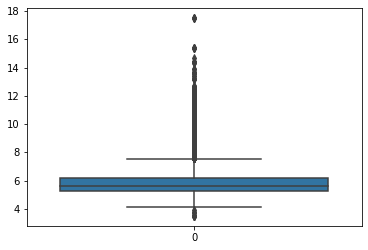

Outliers are : [11533 11534 11535 11536 14874 14875 14876 14877 14878]


In [ ]:
remove_outliers_by_target()

In [ ]:
print('\033[1m' + '\n Shape After Treating Outliers:' + '\033[0m', df_main.shape)


 Shape After Treating Outliers: (15730, 84)


In [ ]:
df_main.describe()

,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,...,Systolic_BP_FR,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine
count,15730.000000,14656.000000,14285.000000,14252.0,15730.000000,15730.000000,15730.000000,15730.000000,15730.000000,14055.000000,...,14243.000000,14243.000000,14843.000000,14843.000000,15507.000000,15438.000000,13082.000000,14440.000000,11827.000000,11388.000000
mean,78543.419135,2.338417,1.703115,2.0,1.547552,53.449460,3.112270,3.250922,1.228481,65.164739,...,124.871024,67.556695,124.876373,67.091289,83.266918,30.084622,1.093869,1.053740,1.220935,2.263347
std,2926.349069,1.597642,1.238498,0.0,0.497749,19.909485,1.094601,1.377932,1.410045,21.523717,...,19.232117,14.141830,19.025894,14.795118,24.163928,7.952651,0.291658,0.225511,0.493977,1.352029
min,73557.000000,0.000000,1.000000,2.0,1.000000,12.000000,1.000000,1.000000,1.000000,14.800000,...,66.000000,0.000000,66.000000,0.000000,29.200000,13.400000,1.000000,1.000000,1.000000,1.000000
25%,75991.000000,1.000000,1.000000,2.0,1.000000,40.000000,3.000000,3.000000,1.000000,49.700000,...,112.000000,60.000000,112.000000,60.000000,66.400000,24.600000,1.000000,1.000000,1.000000,2.000000
50%,78504.000000,1.890000,2.000000,2.0,2.000000,57.000000,3.000000,3.000000,1.000000,61.600000,...,122.000000,68.000000,122.000000,68.000000,79.200000,28.600000,1.000000,1.000000,1.000000,2.000000
75%,81030.000000,3.750000,2.000000,2.0,2.000000,70.000000,4.000000,4.000000,1.000000,80.100000,...,136.000000,76.000000,136.000000,76.000000,96.200000,34.000000,1.000000,1.000000,1.000000,2.000000
max,83729.000000,5.000000,9.000000,2.0,2.000000,80.000000,5.000000,7.000000,77.000000,162.800000,...,228.000000,122.000000,230.000000,116.000000,222.600000,82.900000,2.000000,2.000000,3.000000,9.000000


In [ ]:
df_main = redefine_target_feature(df_main)
df_main.head()


 Redifining the Target Feature to :
 0 - Normal, 1 - Prediabetic, 2 - diabetic: 



,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,...,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine,Diabetes
0,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,...,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0,2.0
1,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,...,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0,2.0
2,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0
3,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0
4,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0


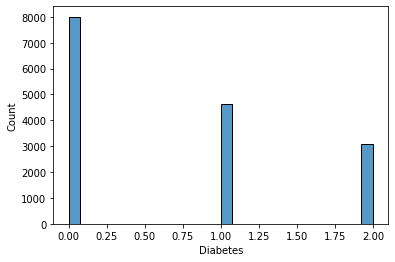

In [ ]:
sns.histplot(data=df_main, x="Diabetes")
plt.show()

# Data Cleaning:

# Need to treat the family_history column as categorical. Do not include in mean 

In [ ]:
featuresTreatedByMedian = ['GlycoHemoglobin', 'SaggitalAbdominal','ArmCircum','GripStrength','Alcohol', 'Thiamin_Med', 'Caffeine_Med', 'Calcium_Med', 'Carbohydrate_Med', 'Total_choline_Med', 'Cholesterol_Med',
                        'Copper_Med', 'Folic_acid_Med', 'Folate_Med', 'Dietary_fiber_Med', 'Iron_Med', 'Energy_Med', 'Lycopene_Med',
                        'Lutein_zeaxanthin_Med', 'Magnesium_Med', 'Zinc_Med', 'Vitamin_B2_Med', 'Vitamin_B6_Med', 'Vitamin_C_Med', 
                        'Vitamin_D_Med', 'Vitamin_K_Med', 'Total_monosaturated_fatty_acids_Med', 'Niacin_Med',
                        'Total_polyunsaturated_fatty_acids_Med', 'Phosphorus_Med', 'Potassium_Med', 'Protein_Med', 'Selenium_Med',
                        'Total_saturated_fatty_acids_Med', 'Sodium_Med', 'Total_sugars_Med', 'Total_fat_Med','Creatinine_urine','skin_rash_allergy_by_quinine',
                        'Overall_Status','Testing_position','Family_History','BP_Time_sec', '60_sec_pulse','Pulse','MIL']

featuresTreatedByOne = ['Breast_fed']

featuresTreatedByMean = ['Glucose_lab', 'Osmolality_lab', 'Triglycerides_lab', 'Blood_urea_nitrogen_lab', 'Albumin_urine_lab', 'Globulin_lab',
                        'Red_cell_distribution_lab', 'Creatinine_lab', 'Potassium_lab', 'Chloride_lab', 'Albumin_lab', 'Sodium_lab',
                        'Direct_HDL_Cholesterol_lab', 'Iron_lab', 'Total_bilirubin_lab', 'Mean_hemoglobin_lab', 'Hepatitis_E_IgG_lab', 
                        'Blood_metal_weights_lab', 'Phosphorus_lab','Insulin','Systolic_BP_FR','Diastolic_BP_FR',
                        'questionable_effort','waist_circum','Systolic_BP_SR','Diastolic_BP_SR','BMI','Weight(kg)']

featuresTreatedByFfill = ['Family_income']

featuresTreatedByCompare = ['Years_in_US']

In [ ]:
df_main = treat_by_lambda(df_main, featuresTreatedByCompare)

In [ ]:
df_main = treat_by_mean(df_main, featuresTreatedByMean)

KeyError: ignored

In [ ]:
df_main = treat_by_median(df_main, featuresTreatedByMedian)

In [ ]:
df_main = treat_by_one(df_main, featuresTreatedByOne)

In [ ]:
df_main = treat_by_ffil(df_main, featuresTreatedByFfill)

In [ ]:
df_main.describe()

,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,...,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine,Diabetes
count,15730.000000,15730.000000,14285.000000,14252.0,15730.000000,15730.000000,15730.000000,15730.000000,15730.000000,14055.000000,...,14243.000000,14843.000000,14843.000000,15507.000000,15438.000000,13082.000000,14440.000000,11827.000000,11388.000000,15730.000000
mean,78543.419135,2.352043,1.703115,2.0,1.547552,53.449460,3.112270,3.250922,1.228481,65.164739,...,67.556695,124.876373,67.091289,83.266918,30.084622,1.093869,1.053740,1.220935,2.263347,0.686968
std,2926.349069,1.606579,1.238498,0.0,0.497749,19.909485,1.094601,1.377932,1.410045,21.523717,...,14.141830,19.025894,14.795118,24.163928,7.952651,0.291658,0.225511,0.493977,1.352029,0.779148
min,73557.000000,0.000000,1.000000,2.0,1.000000,12.000000,1.000000,1.000000,1.000000,14.800000,...,0.000000,66.000000,0.000000,29.200000,13.400000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,75991.000000,1.000000,1.000000,2.0,1.000000,40.000000,3.000000,3.000000,1.000000,49.700000,...,60.000000,112.000000,60.000000,66.400000,24.600000,1.000000,1.000000,1.000000,2.000000,0.000000
50%,78504.000000,1.910000,2.000000,2.0,2.000000,57.000000,3.000000,3.000000,1.000000,61.600000,...,68.000000,122.000000,68.000000,79.200000,28.600000,1.000000,1.000000,1.000000,2.000000,0.000000
75%,81030.000000,3.810000,2.000000,2.0,2.000000,70.000000,4.000000,4.000000,1.000000,80.100000,...,76.000000,136.000000,76.000000,96.200000,34.000000,1.000000,1.000000,1.000000,2.000000,1.000000
max,83729.000000,5.000000,9.000000,2.0,2.000000,80.000000,5.000000,7.000000,77.000000,162.800000,...,122.000000,230.000000,116.000000,222.600000,82.900000,2.000000,2.000000,3.000000,9.000000,2.000000


In [ ]:
df_main = df_main.drop(['GlycoHemoglobin'], axis=1)
df_main.head()

,id,Family_income,Family_History,Breast_fed,Gender,Age_while_screening,Race_Hispanic_Origin,Race_Hispanic_Origin_whAsian,Country_Of_Birth,GripStrength,...,Diastolic_BP_FR,Systolic_BP_SR,Diastolic_BP_SR,Weight(kg),BMI,Testing_position,questionable_effort,Overall_Status,skin_rash_allergy_by_quinine,Diabetes
0,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,...,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0,2.0
1,73557,0.84,1.0,2.0,1,69,4,4,1,55.2,...,72.0,114.0,76.0,78.3,26.7,1.0,1.0,1.0,2.0,2.0
2,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0
3,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0
4,73558,1.78,1.0,2.0,1,54,3,3,1,61.5,...,62.0,160.0,80.0,89.5,28.6,1.0,1.0,1.0,2.0,2.0


In [ ]:
check_for_nulls_per(df_main)

                                       \n Null Values By Count \n  \
Creatinine_urine                                                    10604   
Insulin                                                              8583   
Blood_metal_weights_lab                                              8038   
skin_rash_allergy_by_quinine                                         4342   
Overall_Status                                                       3903   
Testing_position                                                     2648   
GripStrength                                                         1675   
SaggitalAbdominal                                                    1637   
Diastolic_BP_FR                                                      1487   
Systolic_BP_FR                                                       1487   
Magnesium_Med                                                        1478   
Total_polyunsaturated_fatty_acids_Med                                1478   
Zinc_Me

# Selecting 40 features on basis of Correlation:

In [ ]:
df_main = corr_matrix_abs(df_main)

In [ ]:
check_correlation_matrix(df_main)

Diabetes                      1.000000
Glucose_lab                   0.580010
SaggitalAbdominal             0.424776
Age_while_screening           0.408956
Osmolality_lab                0.323013
                                ...   
Chloride_lab                 -0.169668
Iron_lab                     -0.171168
Direct_HDL_Cholesterol_lab   -0.186722
Albumin_lab                  -0.242192
Breast_fed                         NaN
Name: Diabetes, Length: 61, dtype: float64


In [ ]:
df_main = select_best_40_features(df_main)

In [ ]:
df_main.shape

(15730, 40)

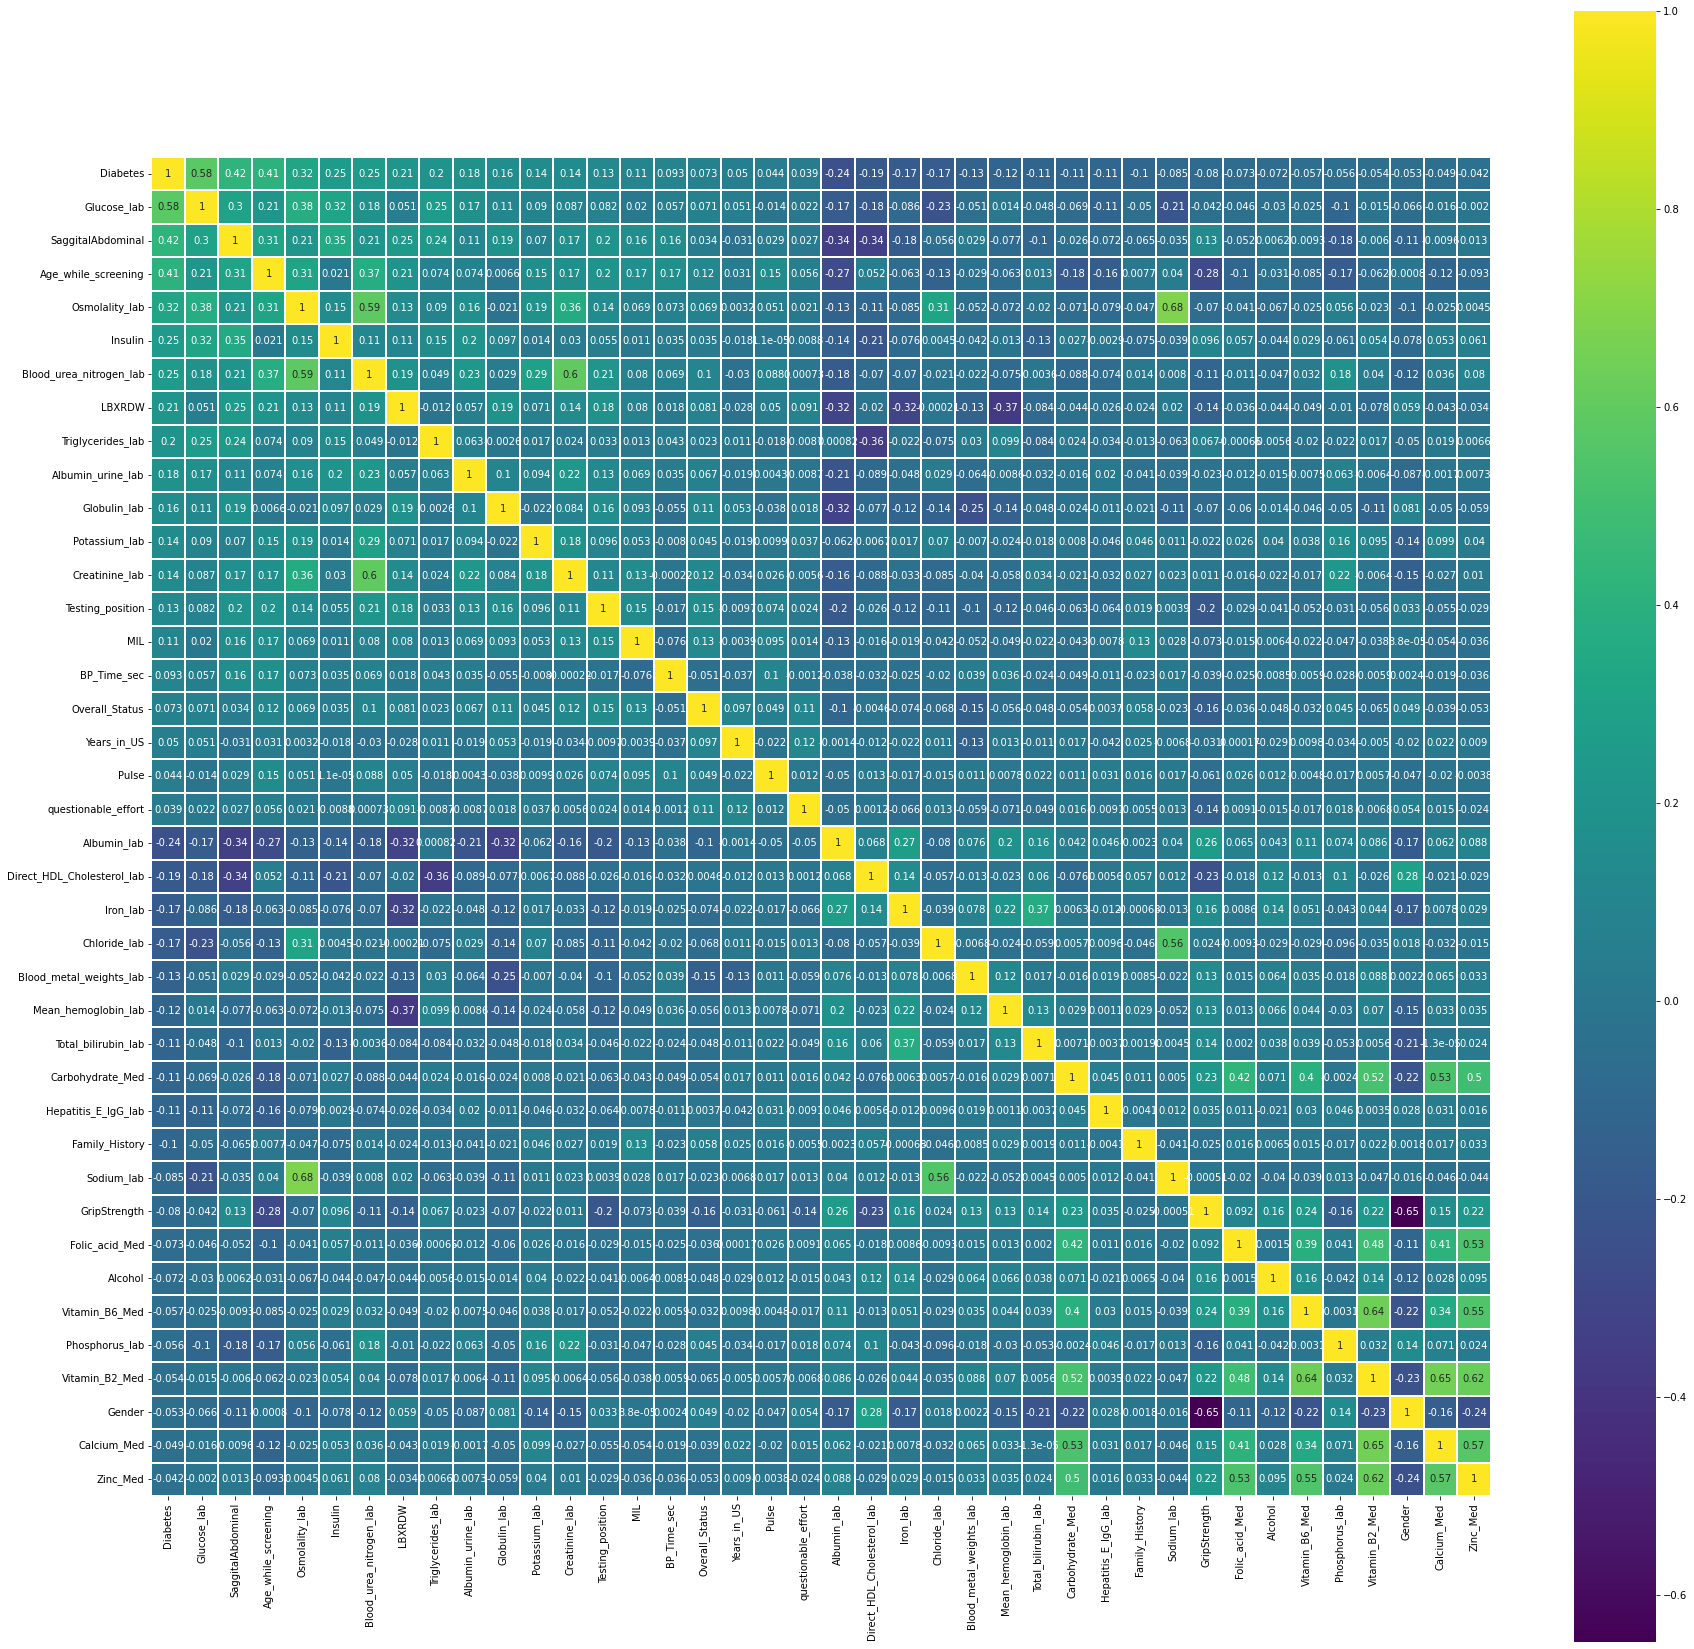

In [ ]:
plot_heatmap(df_main)

# Data Preparation:

## Normalization:

In [ ]:
x = df_main.drop(['Diabetes'], axis=1)
y = df_main[['Diabetes']]
# scaler = MinMaxScaler()
# x = scaler.fit_transform(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [ ]:
# Anova Feature Importance: 
def print_importances(n):
    model = SelectKBest(f_classif,k=20)
    model.fit(x, y)
    # summarize scores
    set_printoptions(precision=3)
    features_ordered = model.scores_.argsort()[-n:][::-1]
    print('\033[1m' + '\n The most important ',n,'features: \n' + '\033[0m')
    for i in range(n):
        print(i,'-',x.columns[features_ordered[i]],': ',np.sort(model.scores_)[-n:][::-1][i])
        
    return features_ordered, model.scores_

def feature_imp_plot(features_ordered, scores_, n):
    imp_features = []
    anova_scores = []
    for i in range(n):
        imp_features.append(x.columns[features_ordered[i]])
        anova_scores.append(np.sort(scores_)[-n:][::-1][i])

    draw_plot(imp_features, anova_scores)

def draw_plot(x,y):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(x, y, color='#52796f')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def feature_imp(model_name, model, X_train):    

  print('\033[1m')
  print(f"Plotting the Feature Importance Graph for the {model_name} :")
  print('\033[0m')
  figure(figsize=(15, 10), dpi=80)


  feat_imp_sort = model.feature_importances_.argsort()
  X_axis = X_train.columns[feat_imp_sort]
  Y_axis = model.feature_importances_[feat_imp_sort]
  X_axis = X_axis[-20:]
  Y_axis = Y_axis[-20:]
  plt.barh(X_axis, Y_axis, color='teal')
  plt.title("Feature Importance - Top 20 Features", fontweight='bold')
  plt.grid(False)
  plt.show()

def plot(y_test, pred, model_name):
  #Plotting Actual Vs Pred

    if model_name == "CatBoostClassifier":
        y_test_f = np.ravel(y_test)
        Actual_Pred = pd.DataFrame({'Actual': y_test_f['Diabetes'], 'Predicted': pred, 'Diff' : pred - y_test_f['Diabetes']})
    else:
        Actual_Pred = pd.DataFrame({'Actual': y_test['Diabetes'], 'Predicted': pred, 'Diff' : pred - y_test['Diabetes']})
    
    Actual_Pred = Actual_Pred.head(25)
    round(Actual_Pred,2)

    Result = Actual_Pred[['Actual','Predicted']]
    Result = Result.reset_index(drop=True)

    Result.plot(marker='o',figsize=(20,7))
    plt.title('Actual vs Predicted', fontsize=14)
    plt.ylabel('Diabetes', fontsize=14)
    plt.grid(False)
    plt.show() 

def model_selected(model_name):
  if model_name == 'CatBoostClassifier':
    model = CatBoostClassifier(verbose=False)
  elif model_name == 'XGBClassifier':
    model = XGBClassifier()
  elif model_name == 'RandomForestClassifier':
    model = RandomForestClassifier()  
  else:
    print("Invalid Model Name!! Please give a proper model name!")
  return model

# Function for training the model
def model_train(model_name,X_train,y_train,X_test,y_test):

  model = model_selected(model_name)

  train_fit = model.fit(X_train, y_train)
    
  #Evaluating the model on the test dataset
  model_score = model.score(X_test, y_test)
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  r2 = r2_score(y_test, pred)
  acc_score = accuracy_score(y_test, pred) * 100
  print('\033[1m')
  print(f"Testing Performance Metrics for the {model_name} :")
  print('\033[0m')
  print("                            R2: {:.2f}".format(r2))
  print("      Mean Squared Error (MSE): {:.2f}".format(mse))
  print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
  print("                      Accuracy: {:.2f}%".format(acc_score))

  if model_name == 'CatBoostClassifier':
    feature_imp(model_name, model, X_train)
    # plot(y_test, pred, model_name)
  elif model_name == 'XGBClassifier':
    feature_imp(model_name, model, X_train)
    plot(y_test, pred, model_name)
  elif model_name == 'RandomForestClassifier':
    feature_imp(model_name, model, X_train)
    plot(y_test, pred, model_name)  

# Feature Selection 

## ANOVA f-test Feature Selection

In [ ]:
features_ordered, scores_ = print_importances(20)
feature_imp_plot(features_ordered, scores_,20)

ValueError: ignored

## CatBoost Feature Importance


Testing Performance Metrics for the CatBoostClassifier :

                            R2: 0.90
      Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.25
                      Accuracy: 94.58%

Plotting the Feature Importance Graph for the CatBoostClassifier :



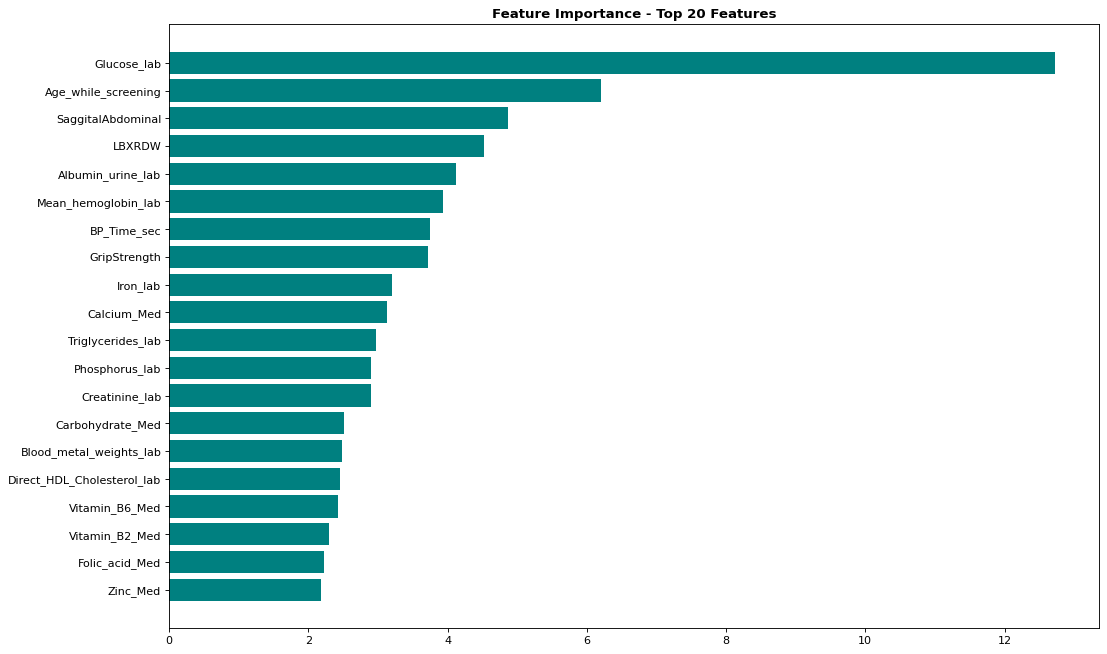

In [ ]:
model_train('CatBoostClassifier',X_train,y_train,X_test,y_test)

## XGBoost Feature Importance


Testing Performance Metrics for the XGBClassifier :

                            R2: 0.90
      Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24
                      Accuracy: 94.60%

Plotting the Feature Importance Graph for the XGBClassifier :



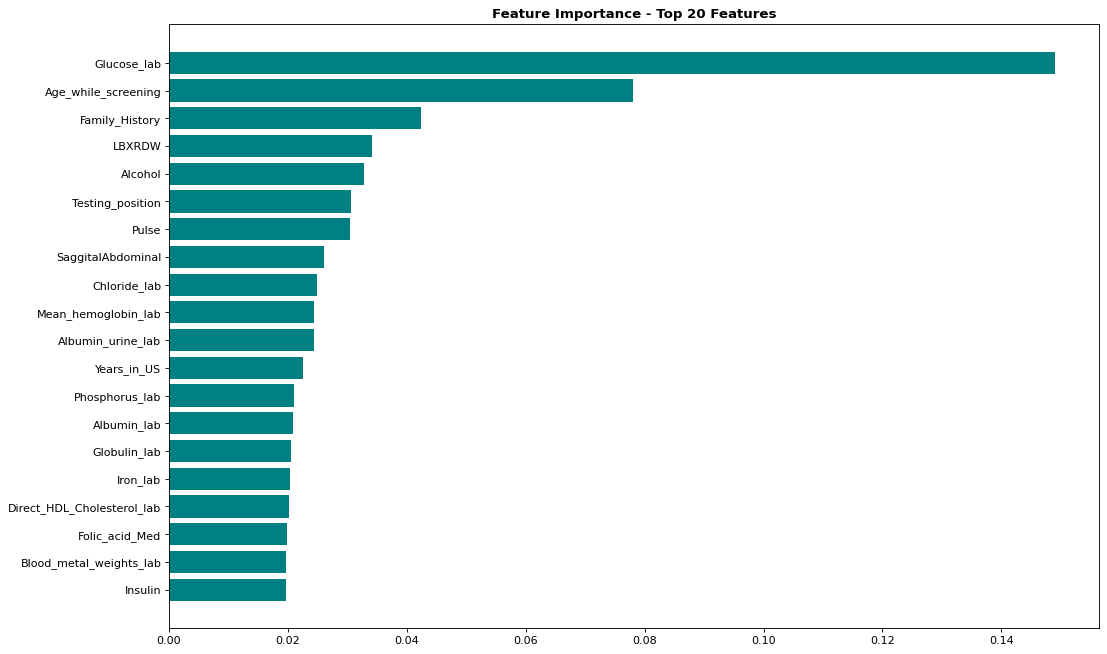

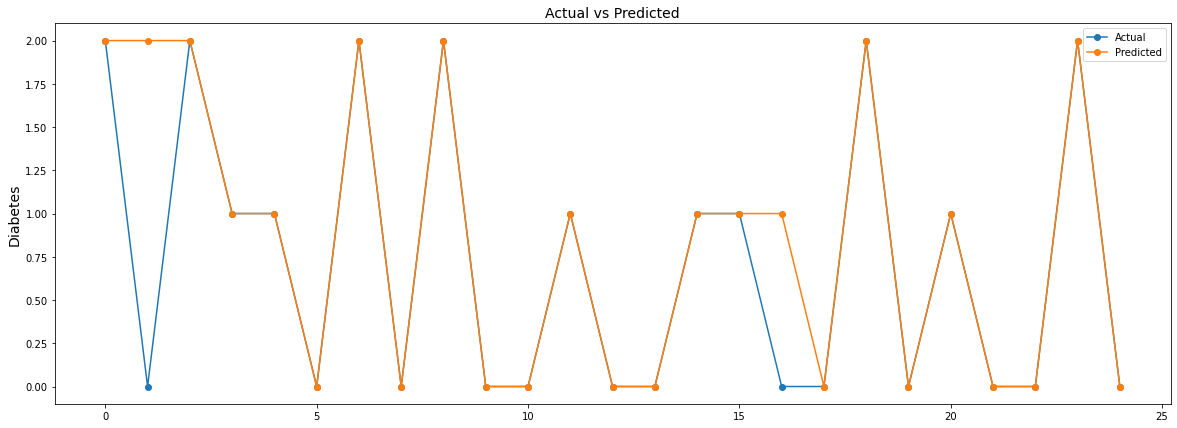

In [ ]:
model_train('XGBClassifier',X_train,y_train,X_test,y_test)

## Random Forest Feature Importance

In [ ]:
model_train('RandomForestClassifier',X_train,y_train,X_test,y_test)

ValueError: ignored

## Logistic Feature Importance

In [ ]:
# Import necessary libraries
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Create logistic regression model
lr = sm.MNLogit(y_train, sm.add_constant(X_train), C = 1, solver = 'liblinear',
                 random_state = 20)

# Fit the model
result = lr.fit(method='bfgs')

# Perform feature selection based on p-values and confidence level
pvalues = result.pvalues[1:]
significant_features = pvalues[pvalues <= 0.05]
selected_features = significant_features.index.tolist()



# Transform training and testing data to contain only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit logistic regression model on selected features
lr_selected = sm.MNLogit(y_train, sm.add_constant(X_train_selected))
result_selected = lr_selected.fit(disp=0)

# Evaluate model on test set
y_pred = result_selected.predict(sm.add_constant(X_test_selected))
y_pred_class = [np.argmax(y) for y in y_pred.values]


print()


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'], annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print()
print(classification_report(y_test, y_pred_class))



In [ ]:
len(selected_features)

In [ ]:
# Get the sorted list of features based on their coefficients
features_with_coef = pd.DataFrame(list(zip(X_train_selected.columns, result_selected.params[1:])), columns=['Feature', 'Coefficient'])
features_sorted_by_coef = features_with_coef.sort_values('Coefficient', ascending=False)

# Get the top 20 significant features based on their coefficients
top_20_features = features_sorted_by_coef.head(20)['Feature'].tolist()

# Print the top 20 significant features
print('Top 20 significant features:')
print(top_20_features)

## Extra Tree Classifier 

In [ ]:
clf = ExtraTreesClassifier(n_estimators=500)
clf = clf.fit(x, y)

features=[]
print(clf.feature_importances_)
features=(clf.feature_importances_).tolist()

[0.116 0.092 0.049 0.03  0.028 0.026 0.032 0.024 0.027 0.021 0.023 0.013
 0.023 0.023 0.01  0.022 0.02  0.005 0.014 0.025 0.024 0.023 0.026 0.026
 0.023 0.021 0.02  0.009 0.02  0.024 0.02  0.019 0.012 0.018 0.022 0.018
 0.013 0.019 0.019]


In [ ]:
print("Features sorted by their score:")
feature_imp = sorted(zip(clf.feature_importances_, df_main.columns), reverse=True)
for score, name in feature_imp:
    print("{}: {}".format(name, round(score, 4)))
    
low_variance_cols = [name for score, name in feature_imp if score < 0.002]
print()
print("Low variance columns: ", low_variance_cols)

Features sorted by their score:
Diabetes: 0.1157
Glucose_lab: 0.092
Age_while_screening: 0.0488
Systolic_BP_FR: 0.0318
SaggitalAbdominal: 0.0305
Osmolality_lab: 0.0278
Triglycerides_lab: 0.0271
Blood_urea_nitrogen_lab: 0.0261
Chloride_lab: 0.0259
Iron_lab: 0.0257
Years_in_US: 0.0248
Red_cell_distribution_lab: 0.0241
Albumin_lab: 0.024
Blood_metal_weights_lab: 0.0238
Insulin: 0.0235
Mean_hemoglobin_lab: 0.0235
Potassium_lab: 0.0233
Overall_Status: 0.0233
Direct_HDL_Cholesterol_lab: 0.0226
Testing_position: 0.0221
Vitamin_B6_Med: 0.0216
Albumin_urine_lab: 0.0213
Family_History: 0.0209
Sodium_lab: 0.0205
MIL: 0.0203
Total_bilirubin_lab: 0.0198
Hepatitis_E_IgG_lab: 0.0197
Gender: 0.0193
GripStrength: 0.0191
Calcium_Med: 0.019
Phosphorus_lab: 0.0181
Alcohol: 0.0179
skin_rash_allergy_by_quinine: 0.0137
Vitamin_B2_Med: 0.0131
Globulin_lab: 0.013
Folic_acid_Med: 0.0124
Creatinine_lab: 0.0102
Carbohydrate_Med: 0.0094
BP_Time_sec: 0.0046

Low variance columns:  []


In [ ]:
feature_imp = sorted(zip(clf.feature_importances_, df_main.columns), reverse=True)
result = [(name, round(score, 4)) for score, name in feature_imp]

low_variance_cols = [name for score, name in feature_imp if score < 0.002]

print("Features sorted by their score:")
print(result)
print()
print("Low variance columns: ", low_variance_cols)

Features sorted by their score:
[('Diabetes', 0.1157), ('Glucose_lab', 0.092), ('Age_while_screening', 0.0488), ('Systolic_BP_FR', 0.0318), ('SaggitalAbdominal', 0.0305), ('Osmolality_lab', 0.0278), ('Triglycerides_lab', 0.0271), ('Blood_urea_nitrogen_lab', 0.0261), ('Chloride_lab', 0.0259), ('Iron_lab', 0.0257), ('Years_in_US', 0.0248), ('Red_cell_distribution_lab', 0.0241), ('Albumin_lab', 0.024), ('Blood_metal_weights_lab', 0.0238), ('Insulin', 0.0235), ('Mean_hemoglobin_lab', 0.0235), ('Potassium_lab', 0.0233), ('Overall_Status', 0.0233), ('Direct_HDL_Cholesterol_lab', 0.0226), ('Testing_position', 0.0221), ('Vitamin_B6_Med', 0.0216), ('Albumin_urine_lab', 0.0213), ('Family_History', 0.0209), ('Sodium_lab', 0.0205), ('MIL', 0.0203), ('Total_bilirubin_lab', 0.0198), ('Hepatitis_E_IgG_lab', 0.0197), ('Gender', 0.0193), ('GripStrength', 0.0191), ('Calcium_Med', 0.019), ('Phosphorus_lab', 0.0181), ('Alcohol', 0.0179), ('skin_rash_allergy_by_quinine', 0.0137), ('Vitamin_B2_Med', 0.0131)

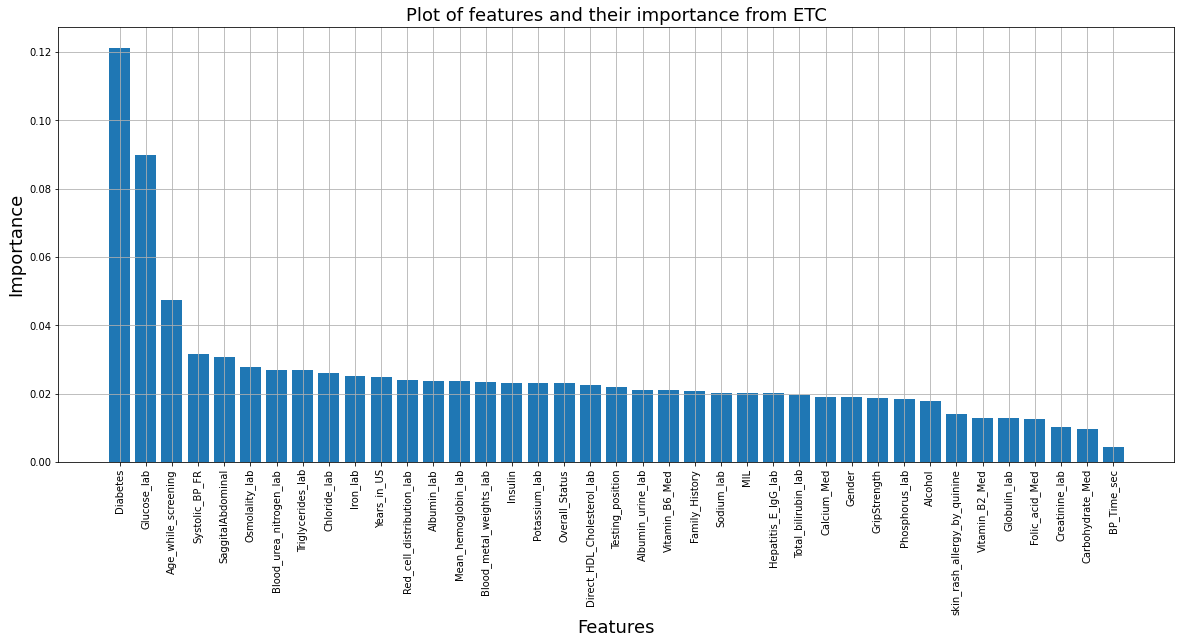

In [ ]:
features_sorted_by_their_score =[('Diabetes', 0.1213), ('Glucose_lab', 0.0898), ('Age_while_screening', 0.0475), ('Systolic_BP_FR', 0.0316), 
                                 ('SaggitalAbdominal', 0.0307), ('Osmolality_lab', 0.0278), ('Blood_urea_nitrogen_lab', 0.027), 
                                 ('Triglycerides_lab', 0.0268), ('Chloride_lab', 0.0259), ('Iron_lab', 0.0253), 
                                 ('Years_in_US', 0.025), ('Red_cell_distribution_lab', 0.0241), 
                                 ('Albumin_lab', 0.0237), ('Mean_hemoglobin_lab', 0.0236), 
                                 ('Blood_metal_weights_lab', 0.0233), ('Insulin', 0.0231), 
                                 ('Potassium_lab', 0.0231), ('Overall_Status', 0.023), 
                                 ('Direct_HDL_Cholesterol_lab', 0.0225), ('Testing_position', 0.022), 
                                 ('Albumin_urine_lab', 0.0212), ('Vitamin_B6_Med', 0.0212), 
                                 ('Family_History', 0.0207), ('Sodium_lab', 0.0203), ('MIL', 0.0203), 
                                 ('Hepatitis_E_IgG_lab', 0.0202), ('Total_bilirubin_lab', 0.0196), ('Calcium_Med', 0.0191), ('Gender', 0.019), ('GripStrength', 0.0188), ('Phosphorus_lab', 0.0184), ('Alcohol', 0.0178), ('skin_rash_allergy_by_quinine', 0.0139), ('Vitamin_B2_Med', 0.0129), ('Globulin_lab', 0.0129), ('Folic_acid_Med', 0.0125), ('Creatinine_lab', 0.0103), ('Carbohydrate_Med', 0.0096), ('BP_Time_sec', 0.0045)]

y_axis = [v for v, k in features_sorted_by_their_score]
x_axis= [k for v, k in features_sorted_by_their_score]

plt.figure(figsize=(20,8))
plt.bar(y_axis, x_axis)
plt.xticks(rotation=90)
plt.xlabel("Features",fontsize=18)
plt.ylabel("Importance",fontsize=18)
plt.title("Plot of features and their importance from ETC",fontsize=18)
plt.grid()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
x = df_main.drop(['Diabetes'], axis=1)
y = df_main['Diabetes']
#selecting features
sfm = SelectFromModel(clf, threshold = 0.002)
sfm.fit(x,y)
support_idx = list(sfm.get_support())
print(support_idx)
print(len(support_idx))


top_20_features = [k for v, k in features_sorted_by_their_score[:20]]


[True, True, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
39


In [ ]:
print("Features sorted by their score:")
feature_imp = sorted(zip(clf.feature_importances_, df_main.columns), reverse=True)
for score, name in feature_imp:
    print("{}: {}".format(name, round(score, 4)))
    
low_variance_cols = [name for score, name in feature_imp if score < 0.002]
print()
print("Low variance columns: ", low_variance_cols)

In [ ]:
print("Top 20 features sorted by their score:")
for score, name in feature_imp[:20]:
    print("{}: {}".format(name, round(score, 4)))

# Mention all the techniques which we need to do

### Feature Selection Models:
- ANOVA (Harsimran)
- Random Forest (Saumya)
- Logistic Regression (Shweta)
- Catboost (Harsimran)
- RFE
- chi-squared
- extra tree 
### Normalization

### EDA Plots (distribution, histogram, etc.)

### Implementing Models
- Baseline Model (decision tree)
- Advanced Models 
        - models:
            - random forest Classifier
            - logistic regression
            - SVM 
            - CatBoost Classifier
            - Naive Bayes
            - decision tree (Baseline)
  - without Hyper-parameter tuning
  - with Hyper-tuning 
- Ensemble Methods
- Evaluation Metrics 

### Performance Analysis
